# Statistical Matching Imputation

This notebook demonstrates how to use MicroImpute's Matching imputer to impute values using the statistical matching approach. Statistical matching (also known as data fusion or synthetic matching) is a technique used to integrate information from different data sources.

In [25]:
# Import needed libraries and setup R environment
import sys
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.datasets import load_diabetes

# Import MicroImpute tools
from microimpute.comparisons.data import preprocess_data
from microimpute.evaluations import *
from microimpute.models import Matching
from microimpute.config import QUANTILES

# Setup R and rpy2
# First, ensure R environment variables are set properly
if 'R_HOME' not in os.environ:
    try:
        import subprocess
        r_home = subprocess.check_output(["R", "RHOME"], universal_newlines=True).strip()
        os.environ['R_HOME'] = r_home
        print(f"Set R_HOME to {r_home}")
    except Exception as e:
        print(f"Could not set R_HOME: {str(e)}")

# Import and initialize rpy2
try:
    import rpy2
    import rpy2.robjects as ro
    from rpy2.robjects import pandas2ri, numpy2ri
    import contextvars  # Important for context handling
    from rpy2.robjects.packages import importr
    
    # Explicitly activate converters
    pandas2ri.activate()
    numpy2ri.activate()
    
    # Try to load base R packages
    base = importr('base')
    utils = importr('utils')
    
    # Check if StatMatch is installed
    print("Checking if StatMatch is installed...")
    utils.chooseCRANmirror(ind=1)  # Choose a CRAN mirror
    
    # Use R to check if package is installed
    is_installed = ro.r('requireNamespace("StatMatch", quietly=TRUE)')[0]
    
    if not is_installed:
        print("Installing StatMatch R package...")
        utils.install_packages("StatMatch")
        print("StatMatch installed successfully")
    
    # Import StatMatch
    StatMatch = importr('StatMatch')
    print("R setup completed successfully")
    
except Exception as r_error:
    print(f"R setup error: {str(r_error)}")
    print("Some cells in this notebook might not execute properly, but documentation will still build.")

# Try alternative ways to find and import r_setup_notebook from _static
try:
    # Method 1: Relative path from current notebook directory
    sys.path.append("../../../_static")
    import r_setup_notebook
    r_setup_success, r_setup_message = r_setup_notebook.setup_r_for_notebook()
    print(f"Method 1: R setup from r_setup_notebook: {r_setup_message}")
except Exception as e1:
    print(f"Method 1 import error: {str(e1)}")
    
try:
    # Method 2: Construct absolute path 
    current_dir = os.path.dirname(os.path.abspath("__file__"))
    static_dir = os.path.abspath(os.path.join(current_dir, "../../../_static"))
    if os.path.exists(static_dir):
        sys.path.append(static_dir)
        import r_setup_notebook
        r_setup_success, r_setup_message = r_setup_notebook.setup_r_for_notebook()
        print(f"Method 2: R setup from r_setup_notebook: {r_setup_message}")
except Exception as e2:
    print(f"Method 2 import error: {str(e2)}")
        
try:
    # Method 3: Find from docs directory
    docs_dir = None
    current = os.getcwd()
    while current != os.path.dirname(current):  # Stop at root
        if os.path.basename(current) == "docs" or os.path.exists(os.path.join(current, "_static")):
            docs_dir = current
            break
        current = os.path.dirname(current)
        
    if docs_dir:
        static_dir = os.path.join(docs_dir, "_static")
        if os.path.exists(static_dir):
            sys.path.append(static_dir)
            import r_setup_notebook
            r_setup_success, r_setup_message = r_setup_notebook.setup_r_for_notebook()
            print(f"Method 3: R setup from r_setup_notebook: {r_setup_message}")
    else:
        print("Could not find docs directory or _static directory")
except Exception as e3:
    print(f"Method 3 import error: {str(e3)}")
    print("Continuing with direct R setup only.")

R setup error: 
    Conversion rules for `rpy2.robjects` appear to be missing. Those
    rules are in a Python `contextvars.ContextVar`. This could be caused
    by multithreading code not passing context to the thread.
    Check rpy2's documentation about conversions.
    
Some cells in this notebook might not execute properly, but documentation will still build.
Method 1: R setup from r_setup_notebook: R setup failed: 
    Conversion rules for `rpy2.robjects` appear to be missing. Those
    rules are in a Python `contextvars.ContextVar`. This could be caused
    by multithreading code not passing context to the thread.
    Check rpy2's documentation about conversions.
    
Method 3: R setup from r_setup_notebook: R setup failed: 
    Conversion rules for `rpy2.robjects` appear to be missing. Those
    rules are in a Python `contextvars.ContextVar`. This could be caused
    by multithreading code not passing context to the thread.
    Check rpy2's documentation about conversions.
    

In [2]:
# Load the diabetes dataset
diabetes = load_diabetes()
df = pd.DataFrame(diabetes.data, columns=diabetes.feature_names)

# Display the first few rows of the dataset
df.head()

,age,sex,bmi,bp,s1,s2,s3,s4,s5,s6
0,0.038076,0.050680,0.061696,0.021872,-0.044223,-0.034821,-0.043401,-0.002592,0.019907,-0.017646
1,-0.001882,-0.044642,-0.051474,-0.026328,-0.008449,-0.019163,0.074412,-0.039493,-0.068332,-0.092204
2,0.085299,0.050680,0.044451,-0.005670,-0.045599,-0.034194,-0.032356,-0.002592,0.002861,-0.025930
3,-0.089063,-0.044642,-0.011595,-0.036656,0.012191,0.024991,-0.036038,0.034309,0.022688,-0.009362
4,0.005383,-0.044642,-0.036385,0.021872,0.003935,0.015596,0.008142,-0.002592,-0.031988,-0.046641


In [3]:
# Define variables for the model
predictors = ["age", "sex", "bmi", "bp"]
imputed_variables = ["s1"]  # We'll impute 's1' (total serum cholesterol)

# Create a subset with only needed columns
diabetes_df = df[predictors + imputed_variables]

# Display summary statistics
diabetes_df.describe()

,age,sex,bmi,bp,s1
count,4.420000e+02,4.420000e+02,4.420000e+02,4.420000e+02,4.420000e+02
mean,-2.511817e-19,1.230790e-17,-2.245564e-16,-4.797570e-17,-1.381499e-17
std,4.761905e-02,4.761905e-02,4.761905e-02,4.761905e-02,4.761905e-02
min,-1.072256e-01,-4.464164e-02,-9.027530e-02,-1.123988e-01,-1.267807e-01
25%,-3.729927e-02,-4.464164e-02,-3.422907e-02,-3.665608e-02,-3.424784e-02
50%,5.383060e-03,-4.464164e-02,-7.283766e-03,-5.670422e-03,-4.320866e-03
75%,3.807591e-02,5.068012e-02,3.124802e-02,3.564379e-02,2.835801e-02
max,1.107267e-01,5.068012e-02,1.705552e-01,1.320436e-01,1.539137e-01


In [4]:
# Split data into training and testing sets
X_train, X_test = preprocess_data(diabetes_df)

# Let's see how many records we have in each set
print(f"Training set size: {X_train.shape[0]} records")
print(f"Testing set size: {X_test.shape[0]} records")

Training set size: 353 records
Testing set size: 89 records


## Simulating Missing Data

For this example, we'll simulate missing data in our test set by removing the values we want to impute.

In [20]:
# Create a copy of the test set with missing values
X_test_missing = X_test.copy()

# Store the actual values for later comparison
actual_values = X_test_missing[imputed_variables].copy()

# Remove the values to be imputed
X_test_missing[imputed_variables] = np.nan

X_test_missing.head()

,age,sex,bmi,bp,s1
287,0.952161,-0.937474,-0.130325,-0.335978,NaN
211,1.943844,-0.937474,0.775037,0.459320,NaN
72,1.333577,1.064282,-0.085057,-0.263679,NaN
321,2.020127,-0.937474,1.091914,1.664559,NaN
73,0.265611,1.064282,-0.424568,-0.046779,NaN


## Training and Using the Matching Imputer

Now we'll train the Matching imputer and use it to impute the missing values in our test set.

In [21]:
# Initialize the Matching imputer
matching_imputer = Matching()

# Fit the model with our training data
# This trains a linear regression model
fitted_matching_imputer = matching_imputer.fit(X_train, predictors, imputed_variables)

In [26]:
# Impute values in the test set
# This uses the trained Matching model to predict missing values
imputed_values = fitted_matching_imputer.predict(X_test_missing, QUANTILES)

# Display the first few imputed values at the median (0.5 quantile)
imputed_values[0.5].head()

Failed to import R's StatMatch package: 
    Conversion rules for `rpy2.robjects` appear to be missing. Those
    rules are in a Python `contextvars.ContextVar`. This could be caused
    by multithreading code not passing context to the thread.
    Check rpy2's documentation about conversions.
    
Unexpected error in statistical matching: Error importing R package: 
    Conversion rules for `rpy2.robjects` appear to be missing. Those
    rules are in a Python `contextvars.ContextVar`. This could be caused
    by multithreading code not passing context to the thread.
    Check rpy2's documentation about conversions.
    
Error in hot deck matching: Statistical matching failed with unexpected error: Error importing R package: 
    Conversion rules for `rpy2.robjects` appear to be missing. Those
    rules are in a Python `contextvars.ContextVar`. This could be caused
    by multithreading code not passing context to the thread.
    Check rpy2's documentation about conversions.
    
Error

RuntimeError: Failed to perform matching: Hot deck matching failed

## Evaluating the Imputation Results

Now let's compare the imputed values with the actual values to evaluate the performance of our imputer.

In [ ]:
# Extract median predictions for evaluation
median_predictions = imputed_values[0.5]

# Create a scatter plot comparing actual vs. imputed values
plt.figure(figsize=(8, 6))
plt.scatter(actual_values, median_predictions, alpha=0.5)
plt.plot([actual_values.min().min(), actual_values.max().max()], 
         [actual_values.min().min(), actual_values.max().max()], 
         'r--')
plt.xlabel('Actual Values')
plt.ylabel('Imputed Values')
plt.title('Comparison of Actual vs. Imputed Values using Matching')
plt.grid(True, linestyle='--', alpha=0.7)
plt.show()

## Examining Quantile Predictions

The Matching imputer can also provide predictions at different quantiles, which can be useful for understanding the uncertainty in the imputation.

In [ ]:
# Compare predictions at different quantiles for the first 5 records
quantiles_to_show = QUANTILES
comparison_df = pd.DataFrame(index=range(5))

# Add actual values
comparison_df['Actual'] = actual_values.iloc[:5, 0].values

# Add quantile predictions
for q in quantiles_to_show:
    comparison_df[f'Q{int(q*100)}'] = imputed_values[q].iloc[:5, 0].values

comparison_df

## Assesing the Method's Performance

To check whether our model is overfitting and ensure robust results we can perform cross-validation and visualize the results.

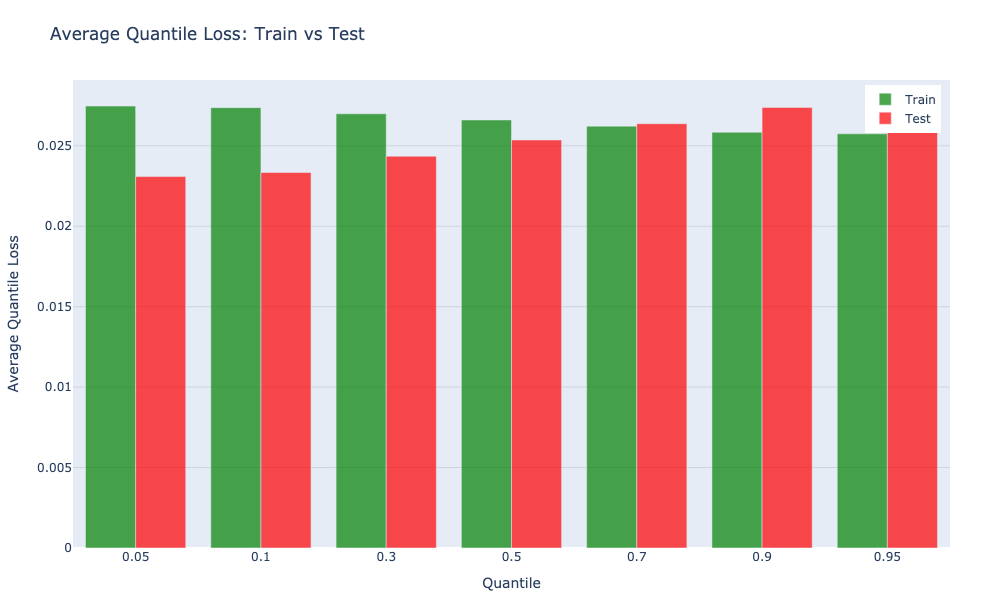

In [ ]:
# Run cross-validation on the same data set 
matching_results = cross_validate_model(
        Matching, diabetes_df, predictors, imputed_variables)

matching_results

In [ ]:
# Plot the results
plot_train_test_performance(matching_results)